## Cross-Entropy/Self-Cross entropy benchmarking

Related paper [Andersen et al, arxiv:2405.17385](https://arxiv.org/abs/2405.17385) (And references therein)



In [1]:
using Revise
using ITensors
using ProgressMeter
using RandomMeas

We first consider a quantum state $\ket{\psi}$ generated by a random brick work circuit of depth $d= 2 \cdot\text{circuit\_layers}$. 

In order to simulate noisy experiment, we consider a simple noise model where after each two layers of unitary evolution, a local depolarization channel is applied. This generates a mixed state evolution $\rho$.

In [2]:
N = 8  # system size (number of qubits)
ξ = siteinds("Qubit", N) # site indices

ψ0 = MPS(ξ,["Dn" for n in 1:N]); # initial state
ρ0 = outer(ψ0',ψ0); # initial density matrix

# Time evolution parameters

number_of_circuit_layers = 20 # circuit depth is 2*number_of_circuit_layers
cutoff = 1e-4 # singular value cutoff for truncating bond dimension
p = 0.05*rand(N) # decoherence strength for the local depolarization acting on each qubit.

8-element Vector{Float64}:
 0.036765848959945134
 0.0029625623362252995
 0.010451808406593044
 0.0068190805859290994
 0.041111504345119614
 0.004761233389281566
 0.010753978857589292
 0.021989756259735177

In [3]:
ψ = Vector{MPS}() # vector to store the pure state evolution
ρ = Vector{MPO}() # vector to store the mixed state evolution
push!(ψ,ψ0)
push!(ρ,ρ0)

@showprogress dt=1 for d in 1:number_of_circuit_layers
        circuit_layer  = random_circuit(ξ,2)
        push!(ψ, apply(circuit_layer, ψ[end]; cutoff=cutoff)) ### Pure state evolution
        ρt = apply(circuit_layer,ρ[end],apply_dag=true;cutoff=cutoff) ### Mixed state evolution (unitary part)
        ρt = apply_depo_channel(ρt,p)  ### Mixed state evolution (local depolarization)
        push!(ρ,ρt);  
end

println("State prepared")
println("with bond dimension (pure state) ", maxlinkdim(ψ[end]))
println("with bond dimension (mixed state) ", maxlinkdim(ρ[end]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


State prepared
with bond dimension (pure state) 15
with bond dimension (mixed state) 232


We now compute the exact fidelity $F=\braket{\psi  | \rho | \psi}$ between the pure state (unitary evolution) and the mixed state (noisy evolution).

In [4]:
F = [real(inner(ψ[d]',ρ[d],ψ[d])) for d in 1:length(ψ)];

We simulate  $N_M$ computational basis measurements.

In [5]:
NM=1000 # number of measurements

measurement_data = Array{MeasurementData}(undef,length(ψ))

for d in 1:length(ψ)
    measurement_data[d] = simulate_local_measurements(ρ[d],NM;mode="dense") # We simulate the measurements in the computational basis.
end

We estimate XEB and Self-XEB fidelity as defined in [Andersen et al, arxiv:2405.17385](https://arxiv.org/abs/2405.17385).


In [6]:
XEB = zeros(Float64,length(ψ))
selfXEB = zeros(Float64,length(ψ))
XEB_c = zeros(Float64,length(ψ))

for d in 1:length(ψ)
    XEB[d] = get_XEB(ψ[d],measurement_data[d])
    selfXEB[d] =  get_selfXEB(ψ[d])
    XEB_c[d] = XEB[d]/selfXEB[d]
end

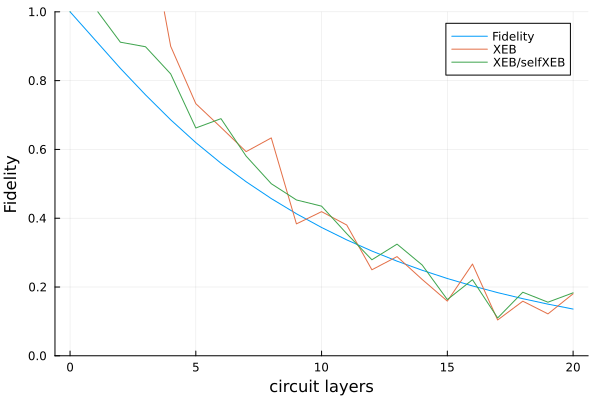

In [7]:
using Plots
plot(0:number_of_circuit_layers,F,label="Fidelity")
plot!(0:number_of_circuit_layers,XEB,label="XEB")
plot!(0:number_of_circuit_layers,XEB_c,label="XEB/selfXEB")
xlabel!("circuit layers")
ylabel!("Fidelity")
ylims!((0,1))